# Detecting P300 ERPs Using the Muse S Headband

In this demo, I showed that we can use the Muse S headband to detect P300 event-related potentials (ERPs) triggered by a visual oddball stimulus. The P300 ERP is a positive, posterior deflection in the ERP waveform that occurs at approximately 300 ms after the onset of an infrequent stimulus. The P300 is a marker for visuospatial attention. The amplitude of the P300 has been shown to be proportional to the amount of attentional resources that are available for stimulus processing.

To test this, I used a visual oddball experimental paradigm, where the subject fixates on a gray screen. A series of circles of either green or blue colour appears on the screen, with the blue (oddball) circle appearing less frequently (25%). The subject is asked to count the number of blue circles that are presented. This experimental setup and data analysis is based on [this paper](http://dx.doi.org/10.1007/978-3-319-58628-1_5) by Krigolson et. al.

In [1]:
%matplotlib inline

import os
import pyxdf
import mne
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Data files
file_names = []
file_dir = r"Data\sub-P001\ses-S001\eeg"
for file in os.listdir(file_dir):
    if file.endswith(".xdf"):
        print(os.path.join(file_dir, file))
        file_names.append(os.path.join(file_dir, file))

# Parameters
time_win = [-0.2, 0.8]
baseline = (0, 0.05)
event_dict = {'control': 1, 'oddball': 2}
reject = dict(eeg=100e-6)

Data\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-oddball_run-001_eeg.xdf
Data\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-oddball_run-002_eeg.xdf
Data\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-oddball_run-003_eeg.xdf
Data\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-oddball_run-004_eeg.xdf
Data\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-oddball_run-005_eeg.xdf


In [3]:
# Find difference between unix epoch timestamps in seconds
def unix_timestamp_diff(t1, t2):
    t1 = datetime.datetime.fromtimestamp(t1)
    t2 = datetime.datetime.fromtimestamp(t2)
    return (t2 - t1).total_seconds()

# Read File
print('Reading XDF file...')
eeg_streams, marker_streams = [],[]
eeg_raws, epochs_list = [], []
for f in range(len(file_names)):    
    # Read streams
    stream, header = pyxdf.load_xdf(file_names[f])
    for i in range(len(stream)):
        stream_type = stream[i]['info']['type'][0]
        if stream_type == 'EEG':
            eeg_streams.append(stream[i])
        elif stream_type == 'Markers':
            marker_streams.append(stream[i])
    
    # Get EEG data
    eeg = eeg_streams[f]
    ch_count = int(eeg['info']['channel_count'][0])
    ch_names = [eeg['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(ch_count)]
    sfreq = int(eeg['info']['nominal_srate'][0])
    eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    eeg_raw = mne.io.RawArray(np.transpose(eeg['time_series'] / 1e6), eeg_info)
    
    # Get marker data
    markers = marker_streams[f]
    onset, duration, description = [], [], []
    marker_timestamp_offset = float(markers['footer']['info']['first_timestamp'][0]) - float(eeg['footer']['info']['first_timestamp'][0])
    for i in range(len(markers['time_series'])):
        onset.append(markers['time_stamps'][i] - markers['time_stamps'][0] + marker_timestamp_offset)
        if i+1 < len(markers['time_series']):
            duration.append(markers['time_stamps'][i+1] - markers['time_stamps'][i])
        else:
            duration.append(0.8)
        description.append(markers['time_series'][i][0])
    annotations = mne.Annotations(onset, duration, description)
    eeg_raw.set_annotations(annotations)
    
    # Bandpass filter
    eeg_raw.filter(0.1, 15., filter_length='auto', l_trans_bandwidth='auto', method='fir', phase='zero',
                   fir_window='hamming', fir_design='firwin', verbose=True)

    # Add raw data to list
    print(eeg_raw)
    eeg_raws.append(eeg_raw)
    
    # Create epochs object
    events, event_id = mne.events_from_annotations(eeg_raw, event_id=event_dict)
    epoch = mne.Epochs(eeg_raw, events, event_id=event_id, tmin=time_win[0], tmax=time_win[1],
                        baseline=baseline, reject=reject, picks='eeg', preload=True)
    print(epoch)
    
    # Artifact rejection
    bad_epochs = []
    for t in range(epoch.get_data().shape[0]):
        is_epoch_bad = False
        for c in range(epoch.get_data().shape[1]):
            # compute gradient
            m, b = np.polyfit(np.arange(0,len(epoch.get_data()[t][c]) / sfreq, 1/sfreq), epoch.get_data()[t][c], 1)
            m = m * 1e6 / 1e3
            if abs(m) >= 10:
                is_epoch_bad = True
                break
        if is_epoch_bad:
            bad_epochs.append(t)
    epoch.drop(bad_epochs)
    
    # Add epoch data to list
    epochs_list.append(epoch)

Reading XDF file...
Creating RawArray with float64 data, n_channels=4, n_times=40716
    Range : 0 ... 40715 =      0.000 ...   159.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 8449 samples (33.004 sec)

<RawArray | 4 x 40716 (159.0 s), ~1.3 MB, data loaded>
Used Annotations descriptions: ['control', 'oddball']
Not setting metadata
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 120 events and 257 or

    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
20 bad epochs dropped
<Epochs |  99 events (all good), -0.199219 - 0.800781 sec, baseline 0 – 0.05 sec, ~804 kB, data loaded,
 'control': 78
 'oddball': 21>
Dropped 0 epochs: 
Creating RawArray with float64 data, n_channels=4, n_times=39564
    Range : 0 ... 39563 =      0.000 ...   154.543 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) meth

In [4]:
# Concatenate epochs
epochs = mne.concatenate_epochs(epochs_list)
epochs

Not setting metadata
Not setting metadata
495 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped


Number of events,495
Events,control: 383oddball: 112
Time range,-0.199 – 0.801 sec
Baseline,0.000 – 0.050 sec


In [5]:
# Average ERPS
evoked_control = epochs['control'].average(picks=['TP9', 'TP10'])
evoked_oddball = epochs['oddball'].average(picks=['TP9', 'TP10'])

# Average TP channels
evoked_control_TP = mne.channels.combine_channels(evoked_control, groups=dict(TP=[0, 1]))
evoked_oddball_TP = mne.channels.combine_channels(evoked_oddball, groups=dict(TP=[0, 1]))

In [6]:
plt.close('all')

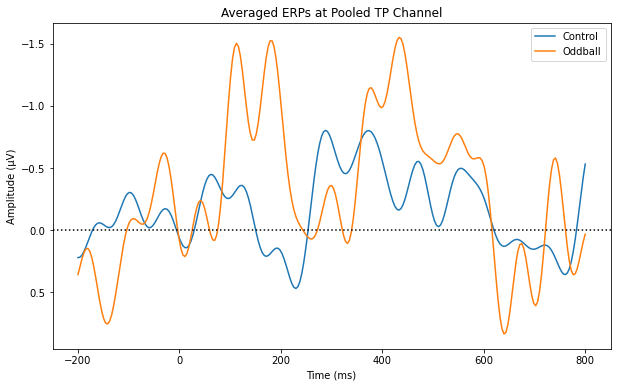

In [7]:
# Plot ERPs
time = np.arange(time_win[0], time_win[0] + evoked_control_TP.get_data().shape[1]/sfreq, 1/sfreq)*1e3
plt.figure(figsize=[10, 6])
plt.plot(time, np.squeeze(evoked_control_TP.get_data() * 1e6))
plt.plot(time, np.squeeze(evoked_oddball_TP.get_data() * 1e6))
plt.title('Averaged ERPs at Pooled TP Channel')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.gca().invert_yaxis()
plt.legend(['Control', 'Oddball'])
plt.axhline(y=0, color='k', linestyle=':')

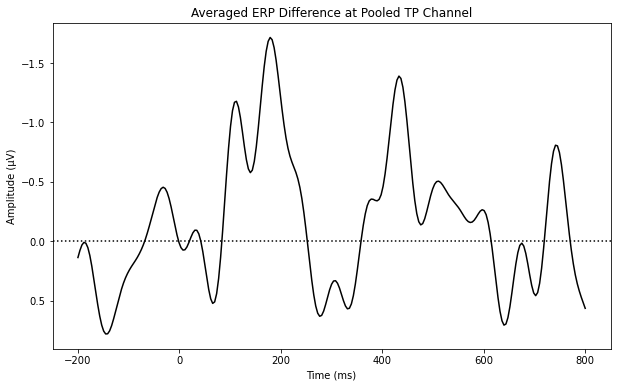

In [8]:
# Plot ERP difference
time = np.arange(time_win[0], time_win[0] + evoked_control_TP.get_data().shape[1]/sfreq, 1/sfreq)*1e3
plt.figure(figsize=[10, 6])
plt.plot(time, np.squeeze(evoked_oddball_TP.get_data() - evoked_control_TP.get_data()) * 1e6, color='k')
plt.title('Averaged ERP Difference at Pooled TP Channel')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.gca().invert_yaxis()
plt.axhline(y=0, color='k', linestyle=':')

From the plots above, we can observe the P300 event as a positive deflection of the ERP component at approximately 300 ms after the stimulus onset.